In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class ReverseSequenceDataset(Dataset):
    def __init__(self, num_samples=5000, seq_len=6, vocab_size=10):
        self.samples = []
        for _ in range(num_samples):
            seq = [random.randint(3, vocab_size - 1) for _ in range(seq_len)]
            self.samples.append((seq, [0] + seq[::-1]))  # prepend <sos>=0

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]
        return torch.tensor(src), torch.tensor(tgt)

def get_dataloaders(batch_size=64):
    dataset = ReverseSequenceDataset()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

In [5]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.size(1)
        hidden = hidden.repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attn_weights = self.v(energy).squeeze(2)
        return torch.softmax(attn_weights, dim=1)


In [6]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden.permute(1, 0, 2), encoder_outputs)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, attn_applied), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = self.fc_out(torch.cat((output.squeeze(1), attn_applied.squeeze(1)), dim=1))
        return output, hidden, attn_weights


In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt):
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        input_token = tgt[:, 0]
        for t in range(1, tgt.size(1)):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs.append(output)
            input_token = tgt[:, t]
        return torch.stack(outputs, dim=1)

    def predict(self, src, max_len):
        encoder_outputs, hidden = self.encoder(src)
        input_token = torch.zeros(src.size(0), dtype=torch.long).to(self.device)
        outputs = []
        for _ in range(max_len):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            input_token = output.argmax(1)
            outputs.append(input_token)
        return torch.stack(outputs, dim=1)

In [8]:
def evaluate(model, dataloader, device):
    model.eval()
    total_sequences = 0
    correct_sequences = 0
    total_tokens = 0
    correct_tokens = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            pred = model.predict(src, max_len=tgt.size(1) - 1)
            tgt_ = tgt[:, 1:]  # remove <sos>
            matches = (pred == tgt_).all(dim=1)
            correct_sequences += matches.sum().item()
            total_sequences += src.size(0)
            correct_tokens += (pred == tgt_).sum().item()
            total_tokens += tgt_.numel()

    print(f"✅ Sequence Accuracy: {correct_sequences / total_sequences:.2f}")
    print(f"✅ Token Accuracy: {correct_tokens / total_tokens:.2f}")


In [9]:
def print_sample_predictions(model, dataloader):
    model.eval()
    src, tgt = next(iter(dataloader))
    src, tgt = src.to(device), tgt.to(device)
    pred = model.predict(src, max_len=tgt.size(1) - 1)
    for i in range(min(5, src.size(0))):
        print("Input     :", src[i].tolist())
        print("Target    :", tgt[i, 1:].tolist())
        print("Predicted :", pred[i].tolist())
        print("✔️ Match!" if torch.equal(tgt[i, 1:], pred[i]) else "❌ Mismatch")
        print("-" * 50)

📉 Epoch 1/12 - Loss: 1.5572
✅ Sequence Accuracy: 0.06
✅ Token Accuracy: 0.55
📉 Epoch 2/12 - Loss: 0.3478
✅ Sequence Accuracy: 0.99
✅ Token Accuracy: 1.00
📉 Epoch 3/12 - Loss: 0.0373
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 4/12 - Loss: 0.0095
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 5/12 - Loss: 0.0040
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 6/12 - Loss: 0.0022
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 7/12 - Loss: 0.0014
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 8/12 - Loss: 0.0010
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 9/12 - Loss: 0.0007
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 10/12 - Loss: 0.0006
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 11/12 - Loss: 0.0005
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00
📉 Epoch 12/12 - Loss: 0.0004
✅ Sequence Accuracy: 1.00
✅ Token Accuracy: 1.00


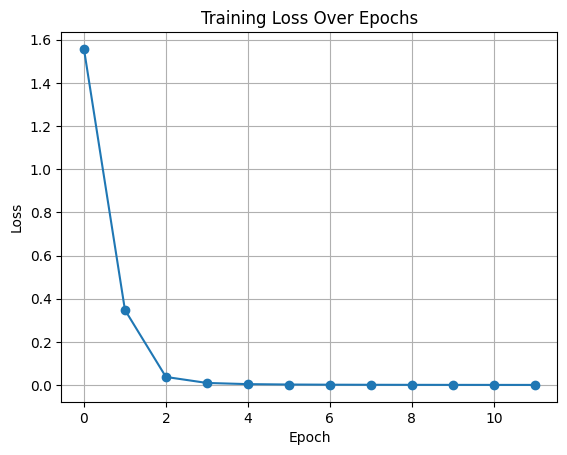

Input     : [4, 5, 8, 6, 3, 6]
Target    : [6, 3, 6, 8, 5, 4]
Predicted : [6, 3, 6, 8, 5, 4]
✔️ Match!
--------------------------------------------------
Input     : [5, 6, 8, 8, 7, 6]
Target    : [6, 7, 8, 8, 6, 5]
Predicted : [6, 7, 8, 8, 6, 5]
✔️ Match!
--------------------------------------------------
Input     : [5, 9, 7, 8, 8, 3]
Target    : [3, 8, 8, 7, 9, 5]
Predicted : [3, 8, 8, 7, 9, 5]
✔️ Match!
--------------------------------------------------
Input     : [7, 7, 6, 3, 9, 3]
Target    : [3, 9, 3, 6, 7, 7]
Predicted : [3, 9, 3, 6, 7, 7]
✔️ Match!
--------------------------------------------------
Input     : [8, 7, 4, 8, 7, 7]
Target    : [7, 7, 8, 4, 7, 8]
Predicted : [7, 7, 8, 4, 7, 8]
✔️ Match!
--------------------------------------------------


In [10]:
INPUT_DIM = OUTPUT_DIM = 10
EMB_DIM = 32
HID_DIM = 64
EPOCHS = 12

train_loader = get_dataloaders()
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM)
attention = Attention(HID_DIM)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, attention)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output = output.view(-1, output.size(-1))
        target = tgt[:, 1:].contiguous().view(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"📉 Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    evaluate(model, train_loader, device)
    losses.append(avg_loss)

# Plotting & Final Output
plt.plot(losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print_sample_predictions(model, train_loader)